In [59]:
# Load Qiskit
from qiskit_ibm_runtime import QiskitRuntimeService, Batch
from dotenv import load_dotenv, find_dotenv
import os

load_dotenv()
API_TOKEN = os.getenv("API_TOKEN")
API_INSTANCE = os.getenv("API_INSTANCE", None)
service = QiskitRuntimeService(channel="ibm_cloud", token=API_TOKEN, instance=API_INSTANCE)
backend = service.backend(name="ibm_rensselaer")


from IPython.display import display

import numpy as np
import qiskit
from qiskit import transpile, QuantumCircuit

In [56]:
from tweedledum import BitVec
from tweedledum.bool_function_compiler import QuantumCircuitFunction
from tweedledum.bool_function_compiler.decorators import circuit_input

from IPython.display import display


# 1/4 of inputs return 1
@circuit_input(vars = BitVec(5))
def simple_esop() -> BitVec(1):
    p1 = (vars[0] & vars[1] & ~vars[2] & vars[3])
    p2 = (vars[1] & ~vars[4])

    return p1 ^ p2 
    
# def print_tt(n_vars: int, f):
#     for input in range(2**n_vars):
#         print(f"{bin(input):07} -> {f(BitVec(n_vars, input))}")

# print_tt(5, simple_esop)

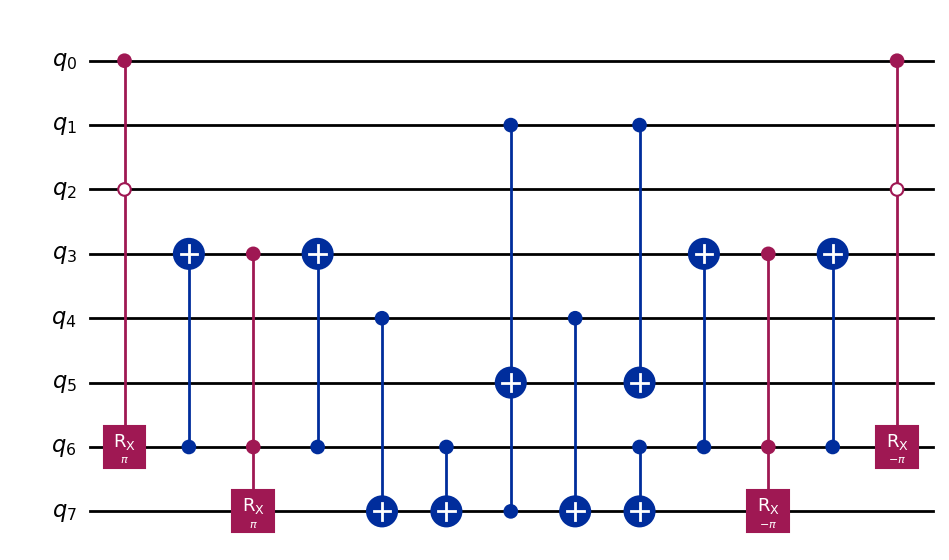

208
OrderedDict([('rz', 163), ('sx', 91), ('ecr', 58), ('x', 20)])


In [120]:
from qiskit import transpile

def compile_func(f, display_transpiled=False):
    qc = QuantumCircuitFunction(simple_esop).synthesize_quantum_circuit()
    display(qc.draw('mpl'))

    transpiled = transpile(qc, backend=backend, optimization_level=3)
    if display_transpiled:
        display(transpiled.draw('mpl'))
    
    return qc, transpiled

qc , transpiled = compile_func(simple_esop, display_transpiled=False)

print(transpiled.depth())
print(transpiled.count_ops())

## ESOP Form 

Exclusive sum-of-products has the form $$ f(x) = p1 \oplus p2 \oplus ... \oplus p_n $$

where each $p_i$ is a sequence of ANDs $x_1 \wedge x_2 \wedge ... \wedge x_k$

## Use in quantum 

We define our oracle as the Unitary operator : $$ \ket{x} \ket{y} \mapsto \ket{x} \ket{y \oplus f(x)} $$

Grover's algorithm specifically needs the operator $$ \ket{x} \mapsto (-1)^{f(x)} \ket{x} $$

We can get by with our first definition because it is easy to turn into the second (only need 4 extra gates). 
However, if $f(x)$ is in ESOP form then we can rewrite it: 
$$ \ket{x} \mapsto (-1)^{p1 \oplus p2 \oplus ... \oplus p_n } \ket{x} = (-1)^{p_1} (-1)^{p_2} ... (-1)^{p_n} \ket{x} $$

Since $p_i$ is a function, this means that $f(x)$ is a sequence of smaller phase oracles, and since $p_i$ is a sequence 


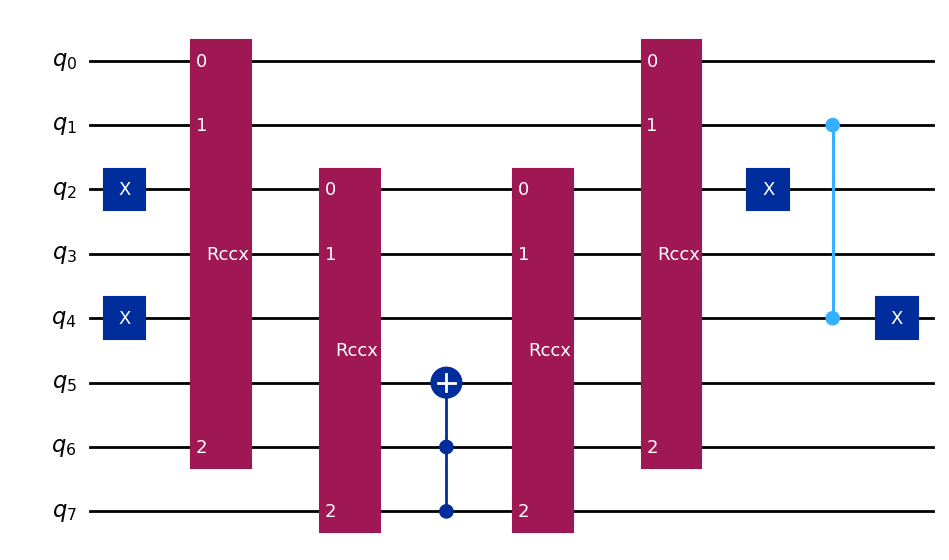

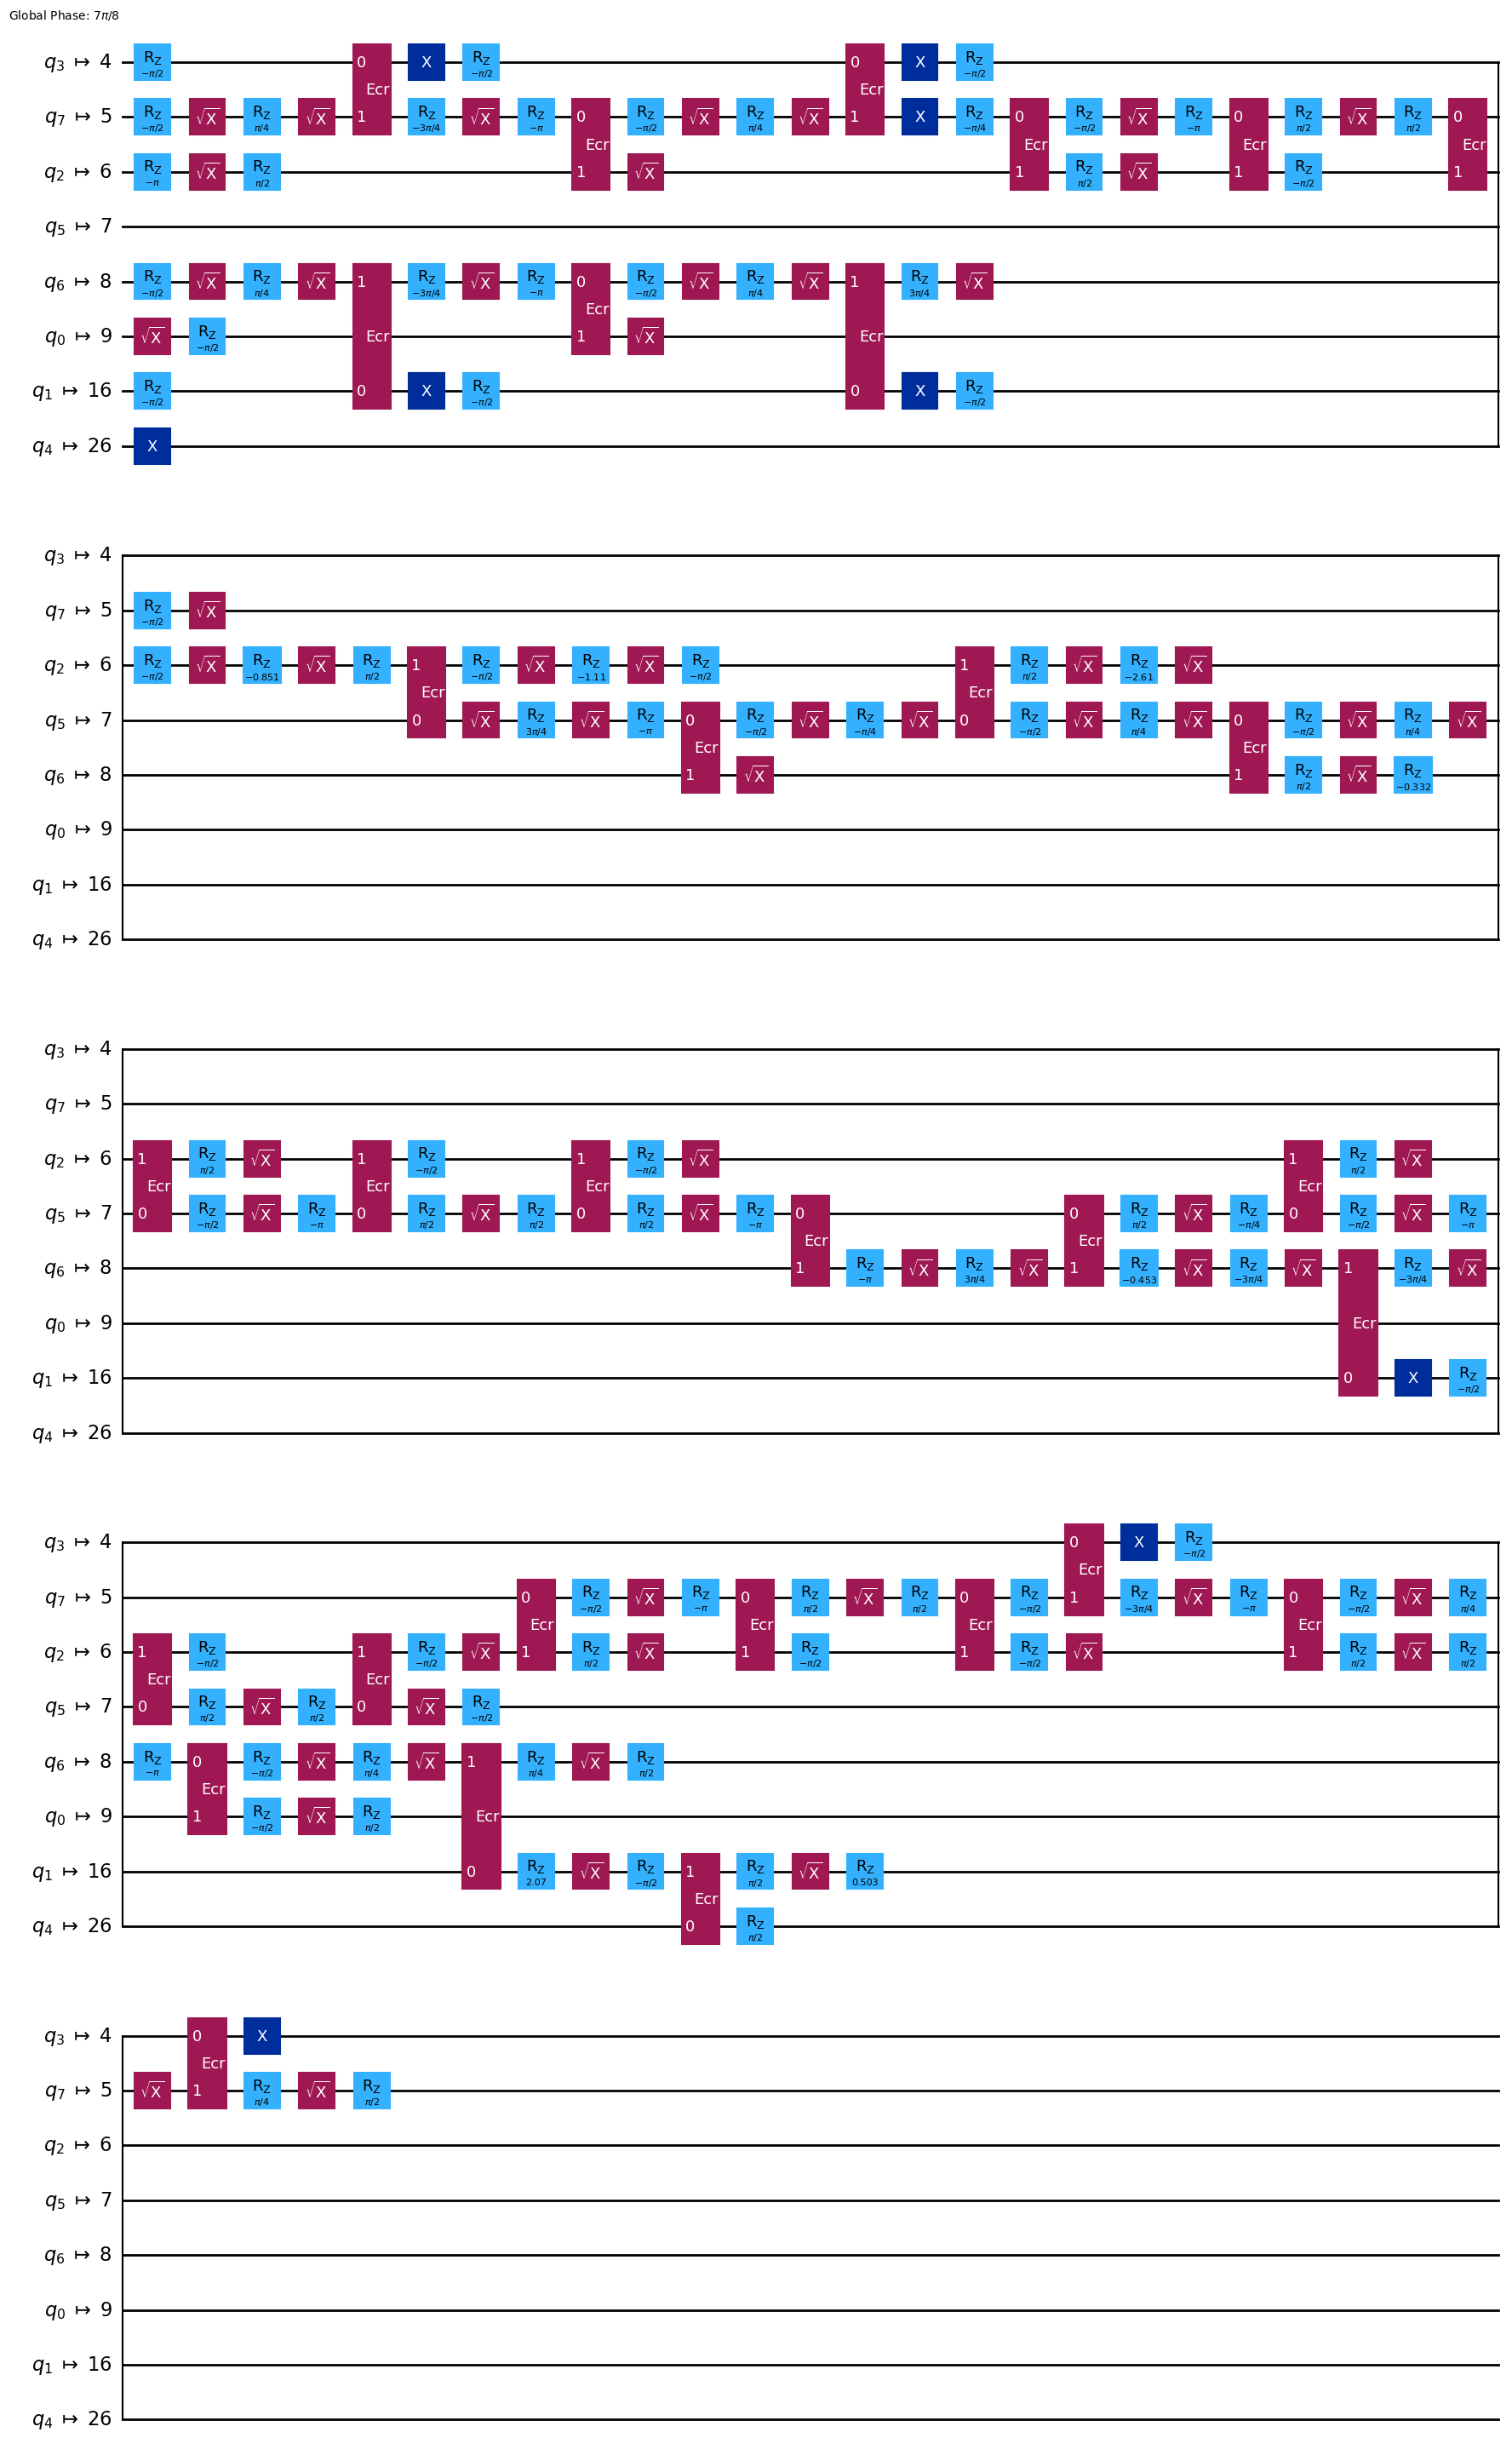

105
OrderedDict([('rz', 102), ('sx', 66), ('ecr', 31), ('x', 9)])


In [130]:
# Inputs:  0 1 2 3 4 
# Ancilla: 6, 7
# Target:  5
esop_qc = QuantumCircuit(8)

# setup target
# esop_qc.x(6)
# esop_qc.h(6)

#  p1 = (vars[0] & vars[1] & ~vars[2] & vars[3])
esop_qc.x(2)
#esop_qc.mcx([0, 1, 2], 6)
esop_qc.rccx(0, 1, 6)
esop_qc.rccx(2, 3, 7)

esop_qc.ccx(6, 7, 5)

esop_qc.rccx(2, 3, 7)
esop_qc.rccx(0, 1, 6)

#esop_qc.mcx([0, 1, 2], 6)

esop_qc.x(2)


# p2 = (vars[1] & ~vars[4])
esop_qc.x(4)
esop_qc.cz(1, 4)
esop_qc.x(4)

#  target
# esop_qc.h(6)
# esop_qc.x(6)

# Inputs:  0 1 2 3 4 
# esop_qc = QuantumCircuit(5)



# #  p1 = (vars[0] & vars[1] & ~vars[2] & vars[3])
# esop_qc.x(2)
# esop_qc.h(3)
# esop_qc.mcx([0, 1, 2], 3)
# esop_qc.h(3)
# esop_qc.x(2)


# # p2 = (vars[1] & ~vars[4])
# esop_qc.x(4)
# esop_qc.cz(1, 4)
# esop_qc.x(4)


display(esop_qc.draw('mpl'))
esop_transpiled = transpile(esop_qc, backend=backend, optimization_level=3)
display(esop_transpiled.draw('mpl'))

print(esop_transpiled.depth())
print(esop_transpiled.count_ops())

## Grover Comparisons


Running Grover with MANUAL Diffusion (N=5, Total Qubits=8)
Optimal iterations for N=5, M=8: 1


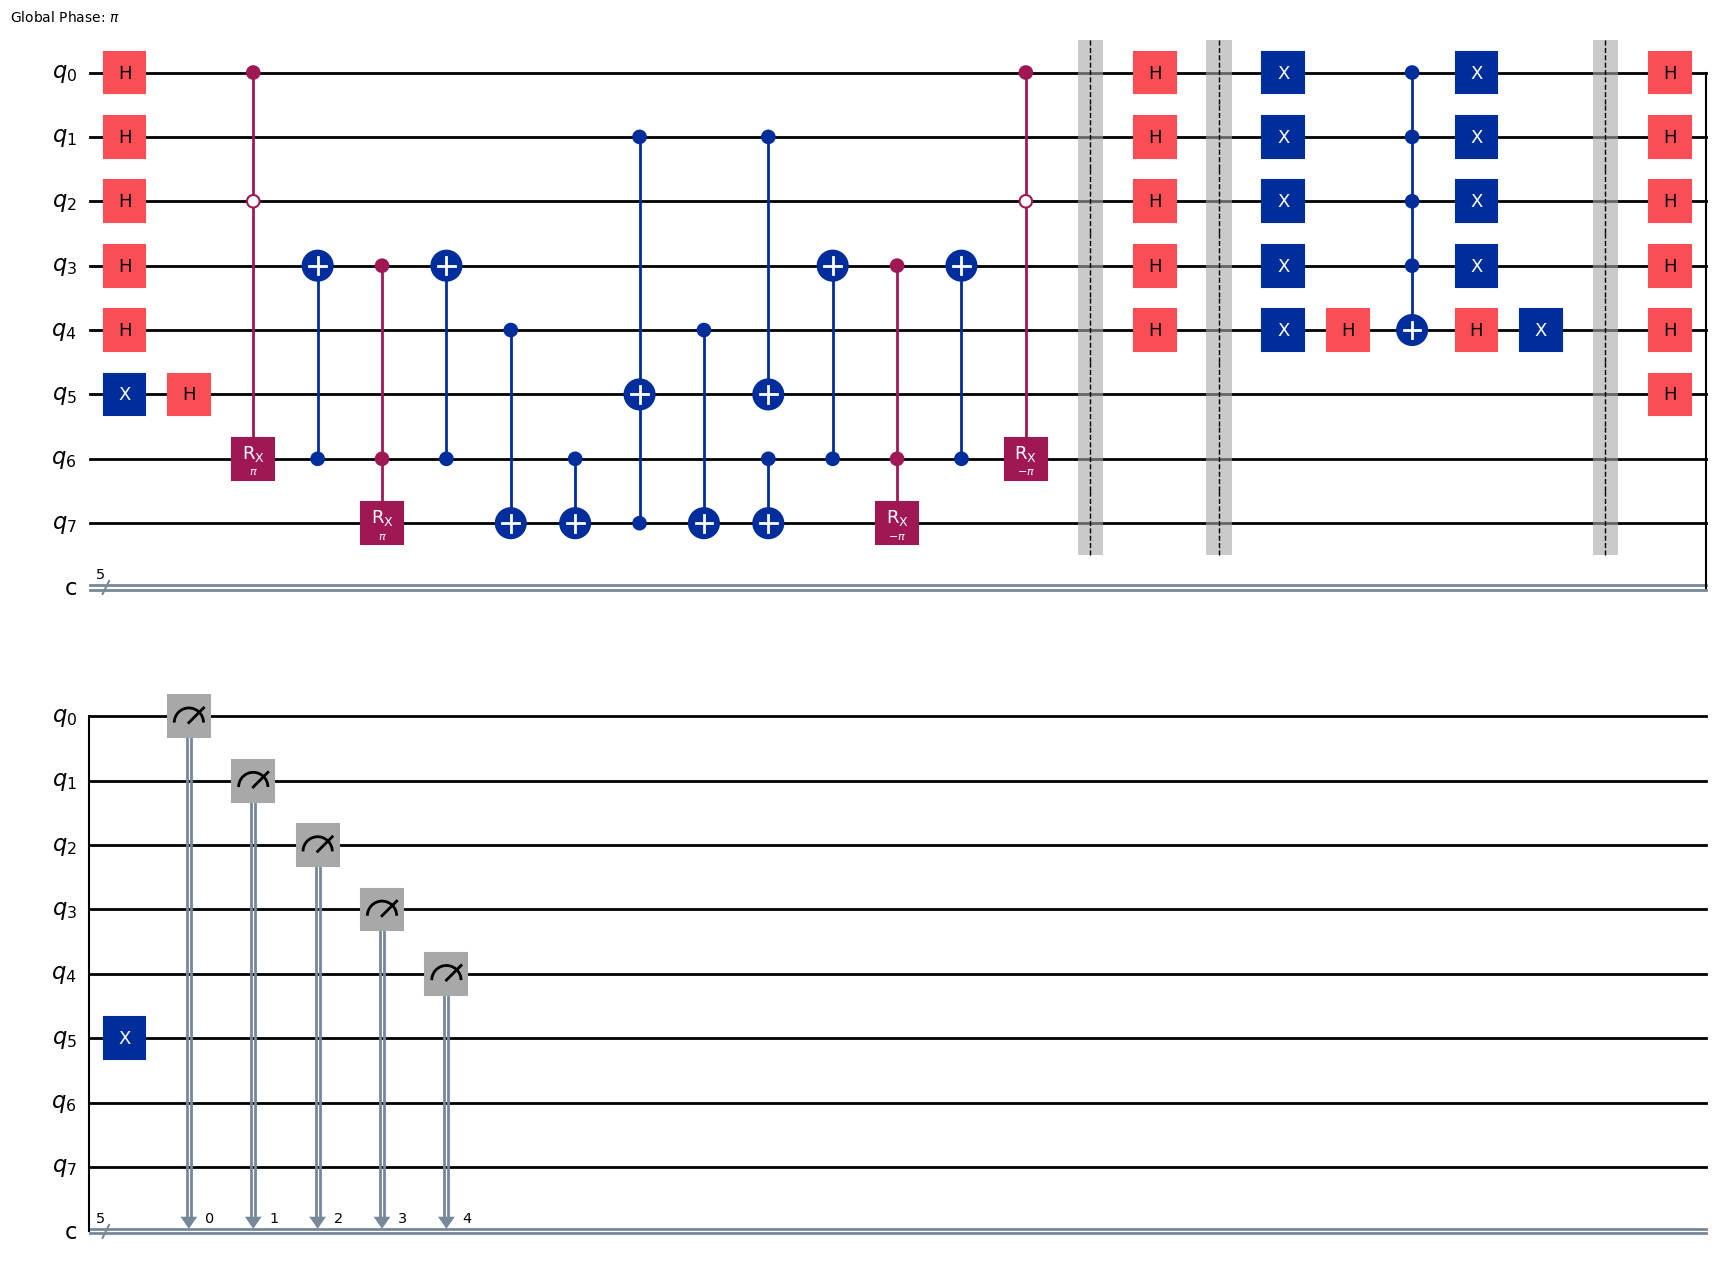

Running simulation...

Running Grover with MANUAL Diffusion (N=5, Total Qubits=8)
Optimal iterations for N=5, M=8: 1


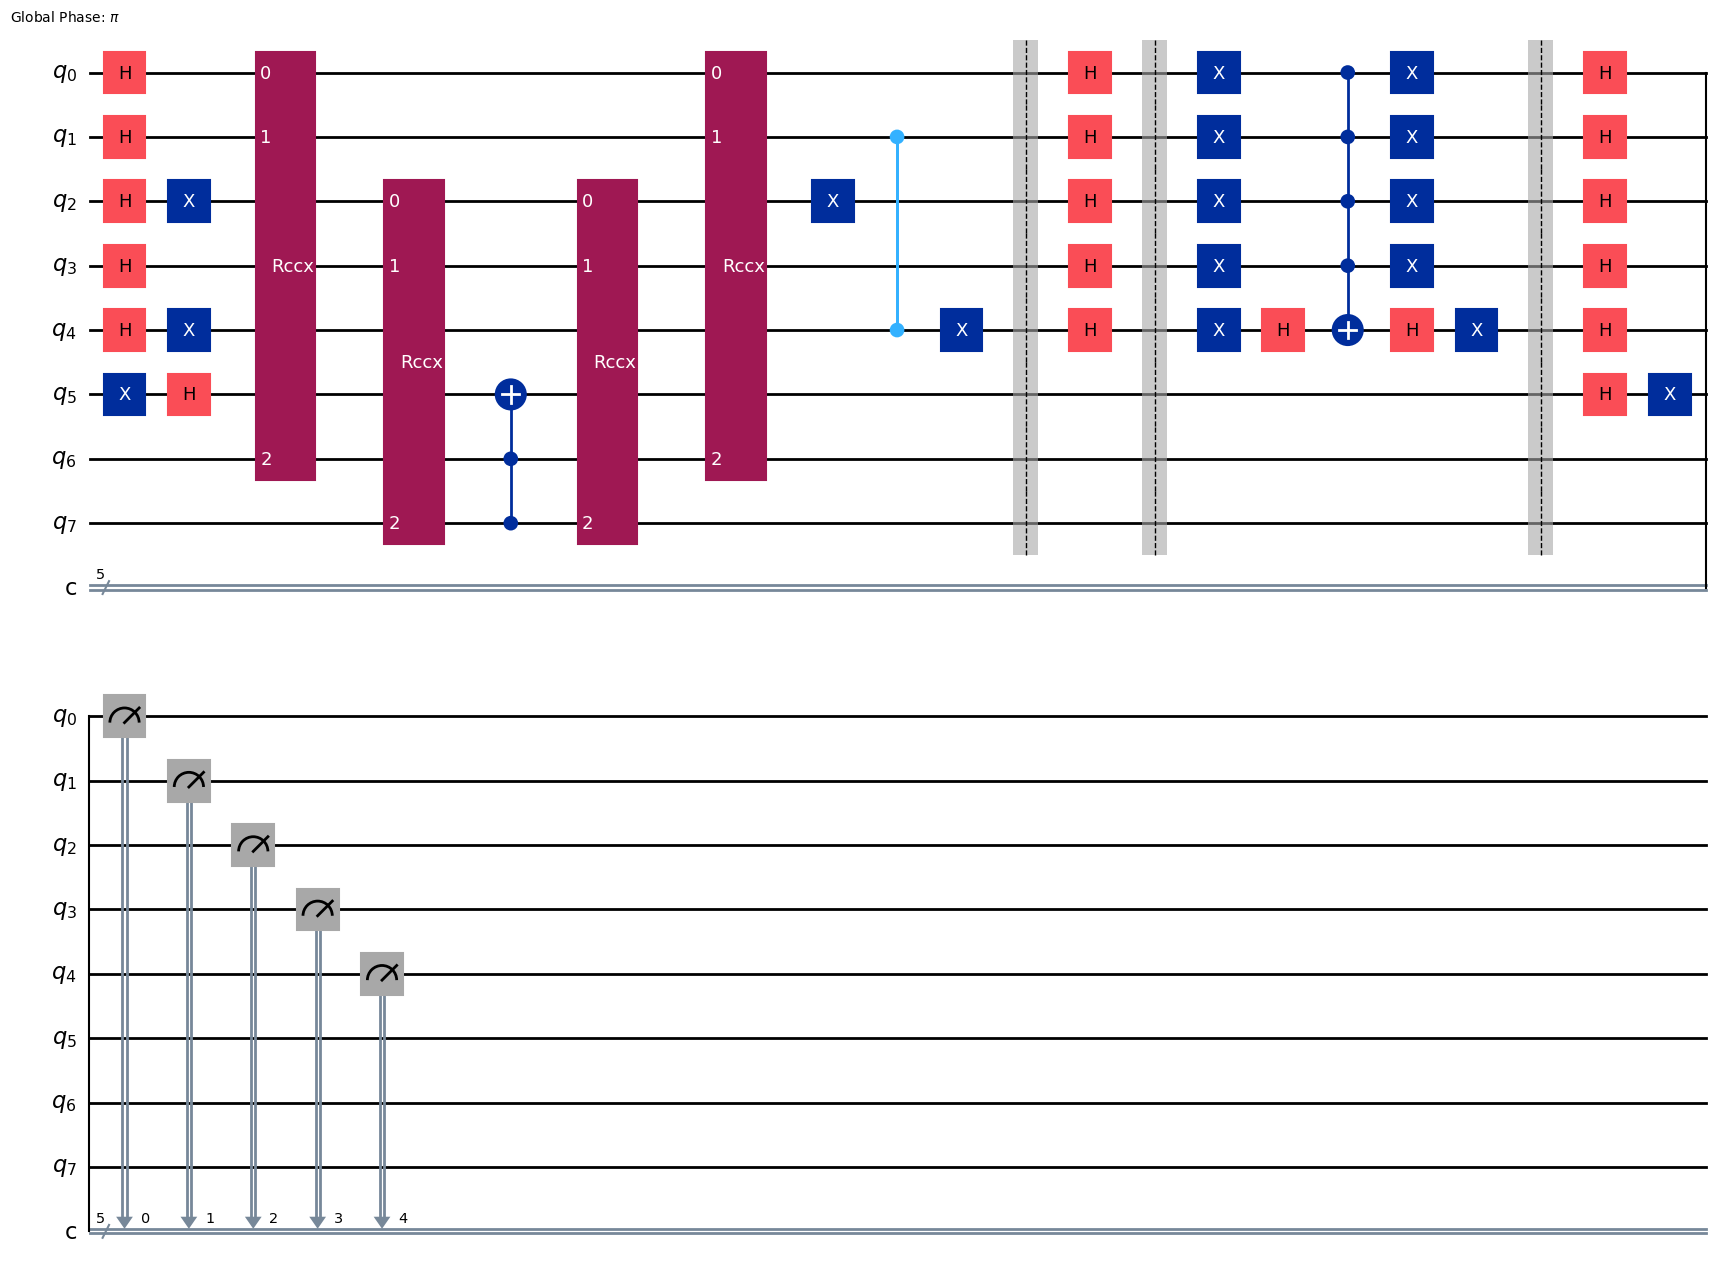

Running simulation...
{'01111': 1272, '00010': 1239, '00110': 1264, '01110': 1228, '11011': 1283, '01010': 1225, '00011': 1287, '00111': 1202}


In [131]:
import qiskit
from qiskit.quantum_info import Statevector
import numpy as np
import math
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import grover_operator
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Assume analyze_counts function is defined as before
# from __main__ import analyze_counts

def find_solution_grover(oracle, num_vertex_qubits, m=1, use_simulator=False):
    """
    Grover's algorithm using a pre-constructed PHASE-FLIP oracle

    Args:
        oracle: The Qiskit QuantumCircuit implementing the phase-flip oracle.
        num_vertex_qubits: The number of qubits in the search space (N).
        m: The estimated number of solutions (default: 1).
        use_simulator: Flag to use AerSimulator.

    Returns:
        A dictionary of measurement counts.
    """
    n = num_vertex_qubits
    if n < 1:
        print("Warning: Number of search qubits must be at least 1.")
        return {}
    total_qubits = oracle.num_qubits
    print(f"\nRunning Grover with MANUAL Diffusion (N={n}, Total Qubits={total_qubits})")

    # Ensure oracle has enough qubits for the search space
    if total_qubits < n:
         raise ValueError(f"Oracle qubit count ({total_qubits}) is less than search space ({n}).")

    # ---  Calculate Iterations ---
    if not (m >= 1 and m <= 2**n):
         print(f"Warning: Number of solutions m={m} is outside valid range [1, 2^N]. Assuming m=1.")
         m = 1

    optimal_iterations = 0
    if m < (1 << n): # Avoid error if m=2^n
        optimal_iterations = math.floor(
            math.pi / (4 * math.asin(math.sqrt(m / (1 << n))))
        )
    print(f"Optimal iterations for N={n}, M={m}: {optimal_iterations}")

    if optimal_iterations == 0 and m > 0:
        print("Warning: Optimal iterations calculated as 0. Grover search may not be effective.")
        # Still run once if you want to see oracle effect
        # optimal_iterations = 1

        
    simulator = AerSimulator()

    search_circuit = qiskit.QuantumCircuit(total_qubits, n) # Classical bits for measuring N search qubits
    search_circuit.h(range(n))
    search_circuit.x(n)
    search_circuit.h(n)

    grover_op = grover_operator(oracle, reflection_qubits=range(n), insert_barriers=True)
    #search_circuit.compose(grover_op.repeat(optimal_iterations), inplace=True)
    search_circuit.compose(grover_op, inplace=True)
    search_circuit.h(n)
    search_circuit.x(n)

    search_circuit.measure(range(n), range(n))
    display(search_circuit.draw('mpl'))

    # ---  Run Simulation ---
    
    # Transpilation is likely needed because mcx might decompose further
    qc = transpile(search_circuit, simulator)
    print("Running simulation...")
    result = simulator.run(qc, shots=10**4).result()
    counts = result.get_counts()


    return counts

qc_sim_counts = find_solution_grover(
    oracle=qc,
    num_vertex_qubits=5,
    m=8,
)

sim_counts_esop = find_solution_grover(
    oracle=esop_qc,
    num_vertex_qubits=5,
    m=8,
)

print(qc_sim_counts)

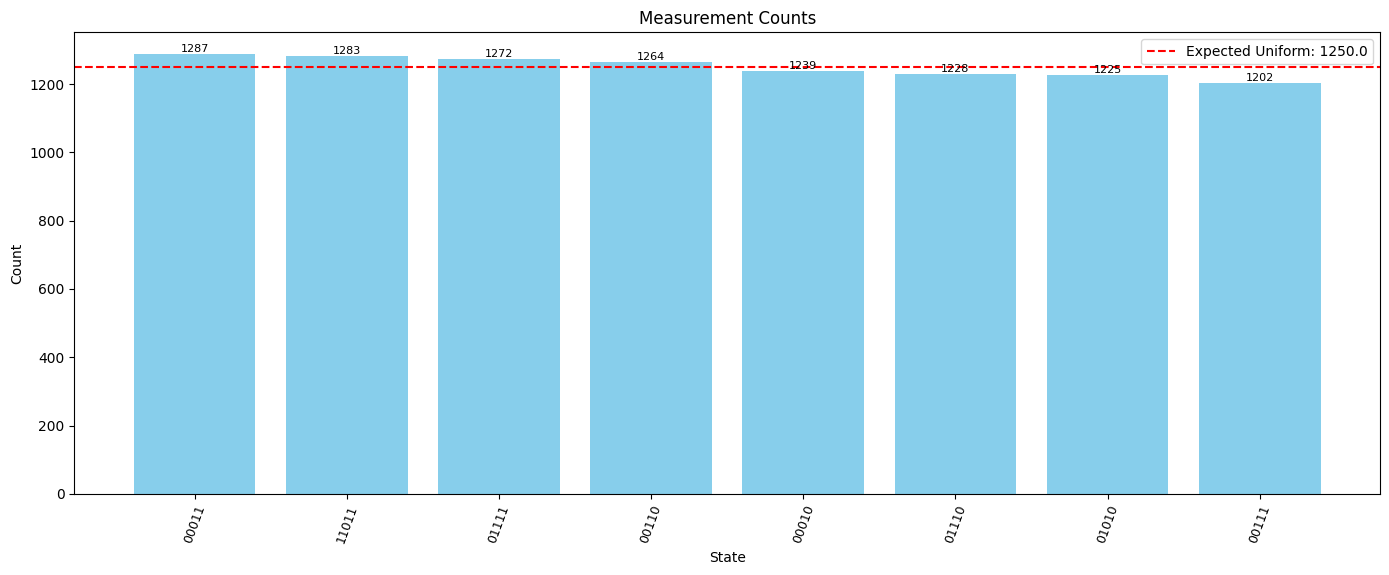

Total samples: 10000
Highest states: ['00011', '11011', '01111'] ([1287, 1283, 1272] counts
Lowest states: ['01110', '01010', '00111'] ([1228, 1225, 1202] counts


None

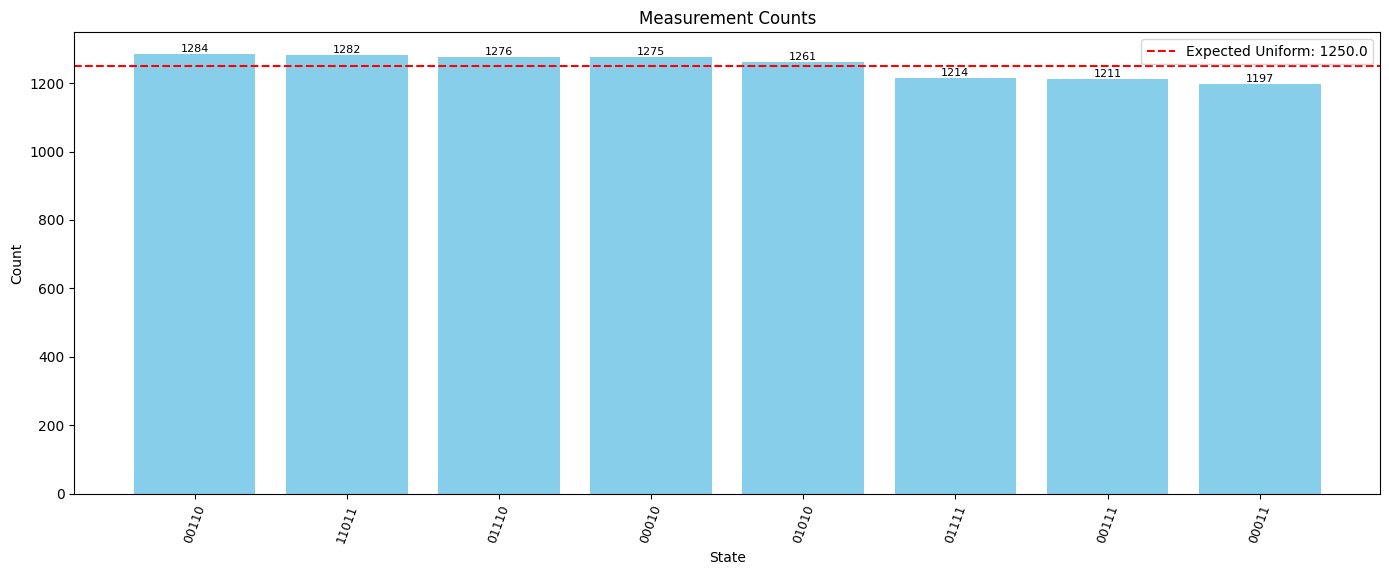

Total samples: 10000
Highest states: ['00110', '11011', '01110'] ([1284, 1282, 1276] counts
Lowest states: ['01111', '00111', '00011'] ([1214, 1211, 1197] counts


None

In [132]:
import matplotlib.pyplot as plt
import numpy as np

def simple_visualize_results(results_dict, title="Quantum Measurement Results"):
    """
    A simple visualization for quantum measurement results.
    
    Parameters:
    -----------
    results_dict : dict
        Dictionary with quantum states as keys and counts as values
    title : str, optional
        Title for the visualization
    """
    # Basic calculations
    total_samples = sum(results_dict.values())
    n_qubits = len(list(results_dict.keys())[0])
    
    # Sort results by count (descending)
    sorted_results = dict(sorted(results_dict.items(), key=lambda x: x[1], reverse=True))
    
    # Create figure with two subplots
    fig, ax1 = plt.subplots(1, 1, figsize=(14, 6))
    
    # 1. Bar chart of states
    bars = ax1.bar(range(len(sorted_results)), sorted_results.values(), color='skyblue')
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom', fontsize=8)
    
    # Set the x-tick positions and labels
    ax1.set_xticks(range(len(sorted_results)))
    ax1.set_xticklabels(list(sorted_results.keys()), rotation=70, fontsize=9)
    
    # Add uniform expectation line
    expected_uniform = total_samples / len(results_dict)
    ax1.axhline(y=expected_uniform, color='red', linestyle='--', 
                label=f'Expected Uniform: {expected_uniform:.1f}')
    
    ax1.set_title('Measurement Counts')
    ax1.set_xlabel('State')
    ax1.set_ylabel('Count')
    ax1.legend()
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Print simple statistics
    print(f"Total samples: {total_samples}")
    print(f"Highest states: {list(sorted_results.keys())[0:3]} ({list(sorted_results.values())[0:3]} counts")
    print(f"Lowest states: {list(sorted_results.keys())[-3:]} ({list(sorted_results.values())[-3:]} counts")



display(simple_visualize_results(qc_sim_counts, ""))
display(simple_visualize_results(sim_counts_esop, ""))


In [133]:
for bitstr in sim_counts_esop.keys():
    if bitstr not in qc_sim_counts:
        print(f"{bitstr} not in sim counts")

In [134]:
from pprint import pprint

pprint(sorted(qc_sim_counts.items()))
pprint(sorted(sim_counts_esop.items()))


[('00010', 1239),
 ('00011', 1287),
 ('00110', 1264),
 ('00111', 1202),
 ('01010', 1225),
 ('01110', 1228),
 ('01111', 1272),
 ('11011', 1283)]
[('00010', 1275),
 ('00011', 1197),
 ('00110', 1284),
 ('00111', 1211),
 ('01010', 1261),
 ('01110', 1276),
 ('01111', 1214),
 ('11011', 1282)]


# Truth Table

In [103]:

def classical_esop(vars) -> bool:
    p1 = (vars[0] & vars[1] & ~vars[2] & vars[3])
    p2 = (vars[1] & ~vars[4])

    return p1 ^ p2 

def print_circuit_truth_table(qc: QuantumCircuit, num_inputs:int, classical_circuit):

    N = qc.num_qubits

    for input in range(2**num_inputs):
        # create input bitstring -- reverse to match qiskit ordering
        input_bitstr = format(input, f'0{N}b')[::-1]
        input_arr = [i == '1' for i in input_bitstr]
        input_arr.extend([0 for _ in range(N - num_inputs)])

        # qiskit state vector simulation
        sv = Statevector.from_int(input, 2**N)
        sv_input = sv.draw(output='latex_source')[2:2 + N]
        sv = sv.evolve(qc)
        sv_out = sv.draw(output='latex_source')

        print(f"{input_bitstr} -> {classical_circuit(input_arr)} \t\t {sv_input} -> {sv_out}")

#print_circuit_truth_table(qc, 5, classical_circuit=classical_esop)
#print_circuit_truth_table(oracle, 5, classical_circuit=classical_esop)
print_circuit_truth_table(esop_qc, 5, classical_circuit=classical_esop)

0000000 -> 0 		 0000000 ->  |0000000\rangle
1000000 -> 0 		 0000001 ->  |0000001\rangle
0100000 -> 1 		 0000010 -> - |0000010\rangle
1100000 -> 1 		 0000011 -> - |0000011\rangle
0010000 -> 0 		 0000100 ->  |0000100\rangle
1010000 -> 0 		 0000101 ->  |0000101\rangle
0110000 -> 1 		 0000110 -> - |0000110\rangle
1110000 -> 1 		 0000111 -> - |0000111\rangle
0001000 -> 0 		 0001000 ->  |0001000\rangle
1001000 -> 0 		 0001001 ->  |0001001\rangle
0101000 -> 1 		 0001010 -> - |0001010\rangle
1101000 -> 0 		 0001011 ->  |0001011\rangle
0011000 -> 0 		 0001100 ->  |0001100\rangle
1011000 -> 0 		 0001101 ->  |0001101\rangle
0111000 -> 1 		 0001110 -> - |0001110\rangle
1111000 -> 1 		 0001111 -> - |0001111\rangle
0000100 -> 0 		 0010000 ->  |0010000\rangle
1000100 -> 0 		 0010001 ->  |0010001\rangle
0100100 -> 0 		 0010010 ->  |0010010\rangle
1100100 -> 0 		 0010011 ->  |0010011\rangle
0010100 -> 0 		 0010100 ->  |0010100\rangle
1010100 -> 0 		 0010101 ->  |0010101\rangle
0110100 -> 0 		 0010110 -